In [2]:
import numpy as np #-> basic data operations
import pandas as pd 
import nlpaug.augmenter.word as naw
import seaborn as sns #->c bonds,used in confusion matrix
import matplotlib.pyplot as plt #-> visulize the data
%matplotlib inline
from matplotlib import style #-> setting the style using the style function
style.use('ggplot') #-> set the style ggplot
import string
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.tokenize import word_tokenize #-> to perform word tokenization
from nltk.corpus import stopwords #-> to perform wordstop
stop_words = set(stopwords.words('english')) #-> set the language as english for our stopword
from nltk.util import pr
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet #-> used in POS 'n,v,adj,etc'
import re #->regex functions used in data cleaning
from nltk.corpus import brown
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import confusion_matrix #->for confusion matrix 

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,accuracy_score #->for our results--to print report,acc,display confusionMAtrix
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [3]:
dataset = pd.read_csv(r"D:\universty.cs\fady project\labeled_data.csv")

In [4]:
classes = ['Hate Speech','Offensive Language','None']

In [5]:
dataset.drop(['count','hate_speech','offensive_language','neither','Unnamed: 0'],axis=1,inplace=True)

In [6]:
dataset.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
dataset.shape

(24783, 2)

Hate Speech  :  1430
Offensive Language  :  19190
None  :  4163


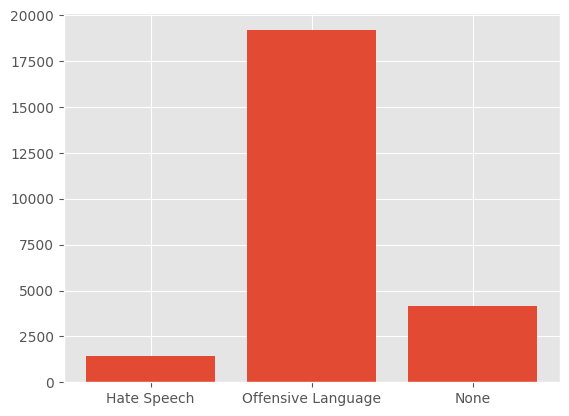

In [8]:
labels = dataset['class']
unique, counts = np.unique(labels, return_counts=True)
values = list(zip(unique, counts))
plt.bar(classes,counts)
for i in values:
    print(classes[i[0]],' : ',i[1])
plt.show()

In [9]:
hate_tweets = dataset[dataset['class']==0]
offensive_tweets = dataset[dataset['class']==1]
neither = dataset[dataset['class']==2]
print(hate_tweets.shape)
print(offensive_tweets.shape)
print(neither.shape)

(1430, 2)
(19190, 2)
(4163, 2)


In [10]:
for i in range(3):
    hate_tweets = pd.concat([hate_tweets,hate_tweets],ignore_index = True)
neither = pd.concat([neither,neither,neither], ignore_index = True)
offensive_tweets = offensive_tweets.iloc[0:12000,:]
print(hate_tweets.shape)
print(offensive_tweets.shape)
print(neither.shape)

(11440, 2)
(12000, 2)
(12489, 2)


In [11]:
dataset = pd.concat([hate_tweets,offensive_tweets,neither],ignore_index = True)
dataset.shape

(35929, 2)

Hate Speech  :  11440
Offensive Language  :  12000
None  :  12489


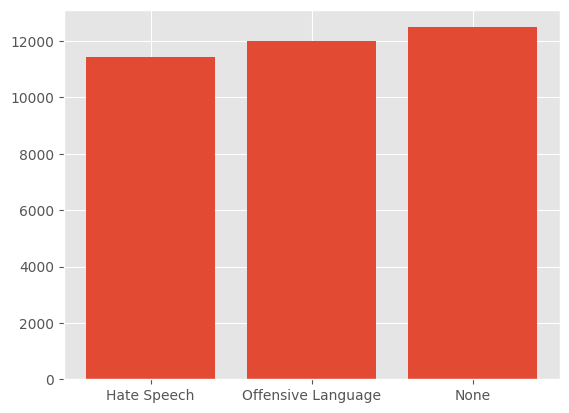

In [12]:
labels = dataset['class']
unique, counts = np.unique(labels, return_counts=True)
values = list(zip(unique, counts))
plt.bar(classes,counts)
for i in values:
    print(classes[i[0]],' : ',i[1])
plt.show()

In [13]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

# PreProcessing

In [14]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english") 

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

#remove emoji
def remove_special_characters(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets

print(dataset[["processed_tweets"]].head(10))

                                    processed_tweets
0                                       queer gaywad
1           alsarabsss he beaner smh tell he mexican
2      fuck gay blacklist hoe hold tehgodclan anyway
3       lmfaoooo hate black peopl black peopl nigger
4                                 least nigger lmfao
5  ariza snake coward least crippl like hero roac...
6  drake new shoe releas nike jordan ye glitter s...
7  gerryshalloweenparti halloween yesterday stupi...
8                    bore suppos cute faggot sometim
9      lassen cc coach want feel youll get nig doubt


In [14]:
dataset['tokenized'] = dataset['processed_tweets'].apply(word_tokenize)
dataset.head()

,class,tweet,processed_tweets,tokenized
0,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...",queer gaywad,"[queer, gaywad]"
1,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ...",alsarabsss he beaner smh tell he mexican,"[alsarabsss, he, beaner, smh, tell, he, mexican]"
2,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b...",fuck gay blacklist hoe hold tehgodclan anyway,"[fuck, gay, blacklist, hoe, hold, tehgodclan, ..."
3,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...",lmfaoooo hate black peopl black peopl nigger,"[lmfaoooo, hate, black, peopl, black, peopl, n..."
4,0,"""@NoChillPaz: ""At least I'm not a nigger"" http...",least nigger lmfao,"[least, nigger, lmfao]"


In [16]:
# Extract features using the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.75, min_df=1)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
print(tfidf.shape)

(35929, 94728)


In [17]:
# If you don't specify the random_state in the code,
# then every time you run(execute) your code a new random value is generated
# and the train and test datasets would have different values each time

X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [18]:
#SVM
support =LinearSVC(random_state=42)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
precision3 = precision_score(y_test,y_preds,average='weighted')
recall3 = recall_score(y_test,y_preds, average='weighted')
f13 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:",acc3,"-> {:.2f}%".format(acc3*100))
print("SVM, pre Score:",precision3,"-> {:.2f}%".format(precision3*100))
print("SVM, recall Score:",recall3,"-> {:.2f}%".format(recall3*100))
print("SVM, f1-score:",f13,"-> {:.2f}%".format(f13*100))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2313
           1       1.00      0.90      0.95      2437
           2       0.95      1.00      0.97      2436

    accuracy                           0.96      7186
   macro avg       0.97      0.97      0.96      7186
weighted avg       0.97      0.96      0.96      7186

SVM, Accuracy Score: 0.9645143334261063 -> 96.45%
SVM, pre Score: 0.9659118344160975 -> 96.59%
SVM, recall Score: 0.9645143334261063 -> 96.45%
SVM, f1-score: 0.9640926016746006 -> 96.41%


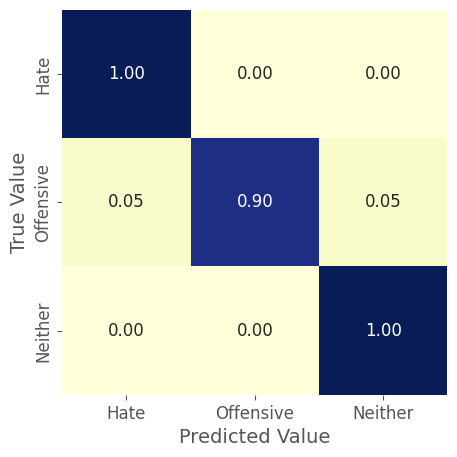

In [19]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [20]:
# Replace the tweet_text with your tweet
tweet_text = "lets kill jews and lets kill them for fun"

# Transform the tweet into a TF-IDF feature vector
tweet_tfidf = tfidf_vectorizer.transform([tweet_text])

# Predict the class label of the tweet using the trained LinearSVC model
class_label = support.predict(tweet_tfidf)[0]

# Get the distance of the tweet feature vector from the decision boundary of each class
distances = support.decision_function(tweet_tfidf)[0]

# Convert the distances into probability estimates using the softmax function
class_probs = np.exp(distances) / np.sum(np.exp(distances))

# Print the class label and its corresponding percentage probability
print("Class label: ", class_label)
print("Percentage probabilities - Hate: {:.2f}%, Offensive: {:.2f}%, Neither: {:.2f}%".format(class_probs[0]*100, class_probs[1]*100, class_probs[2]*100))


Class label:  0
Percentage probabilities - Hate: 72.60%, Offensive: 10.74%, Neither: 16.66%


In [21]:
import pickle
pickle.dump(support,open('t.pkl','wb'))

In [22]:
with open("tf.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

# Data Augmentation